In [93]:
from sklearn.model_selection import ParameterGrid
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math
from sklearn.impute import KNNImputer
from fbprophet import Prophet
import numpy as np
import re
import statistics

def show_results(mae_values, mpe_values):
    avg_mae = statistics.mean(mae_values)
    avg_mpe = statistics.mean(mpe_values)
    med_mae = statistics.median(mae_values)
    med_mpe = statistics.median(mpe_values)
    print('Average MAE: %.3f' % avg_mae)
    print('Median MAE: %.3f' % med_mae)
    print('Average MAPE: %.3f' % avg_mpe)
    print('Median MAPE: %.3f' % med_mpe)
    
def to_zipcode(tuple_string):
    return f"{int(re.search(r'[0-9]+', tuple_string).group()):05d}"

def train_and_test_prophet_TUNING(data, pc, cps, testset_size=4):     
    
    train, test = train_test_split(data, testset_size)
    train_imp = knn_imputation_for_data(train, "Quarter")
    
    df_train = train_imp[[pc, "Quarter"]].rename(columns={pc:"y","Quarter":"ds"})
    df_test = test[[pc, "Quarter"]].rename(columns={pc:"y","Quarter":"ds"})
    
    prop = Prophet(changepoint_prior_scale=cps)
    prop.fit(df_train)
    forecast = prop.predict(df_test)
    new_test, new_forecast = remove_nan_from_test(df_test, forecast)
    mae = mean_absolute_error(new_test, new_forecast)
    rmse = math.sqrt(mean_squared_error(new_test, new_forecast))
    mpe = mean_absolute_percentage_error(new_test, new_forecast)
    return mae, rmse, mpe, pc, forecast
        #return -1, -1, -1, -1, -1

def select_best_parameter_and_index(mpe_grid, grid):
    best_grid = grid[np.argmin(mpe_grid)]
    index = np.argmin(mpe_grid)
    return best_grid, index

def knn_imputation_for_data(data, time_column):
        num_columns = list(data.columns)
        num_columns.remove(time_column)

        quarter = data[time_column]
        numeral = data[num_columns]
        imputer = KNNImputer(n_neighbors=5)
        knn_imputed = imputer.fit_transform(numeral)
        data_imp = pd.DataFrame(knn_imputed, columns=num_columns)
        data_imp["Quarter"] = quarter
        return data_imp

def train_test_split(data, testset_size):
    train = data[:-testset_size].reset_index()
    test = data[-testset_size:].reset_index()
    return train, test

# If our validation set contains Nan, lets remove it from comparison
def remove_nan_from_test(test, forecast):
    test = list(test["y"])
    forecast = list(forecast["yhat"])
    new_test = []
    new_forecast = []
    for i in range(len(test)):
        if not math.isnan(test[i]):
            new_test.append(test[i])
            new_forecast.append(forecast[i])
    return new_test, new_forecast

In [110]:
### Regex to change quarters to datetime
import datetime as date

df = pd.read_csv("quarterly_data.csv", encoding = 'unicode_escape')
df_quartered = df.melt(id_vars=["Postal code", "Building type"],var_name="Quarter", value_name="EUR/m2")

def quarter_to_datetime(row):
    dates = {"Q1": "1/1", "Q2":"1/4", "Q3":"1/7", "Q4":"1/10"}
    string = row.replace("*", "").split(" ")[0]
    year, quarter = string[:4], string[4:]
    datetime_str = dates[quarter] + "/" + year
    return date.datetime.strptime(datetime_str, '%d/%m/%Y')
    
    
df_quartered["Quarter"] = df_quartered["Quarter"].apply(lambda row: quarter_to_datetime(row))
df_quartered[['Postal code', 'Location']] = df_quartered['Postal code'].str.split(' ', 1, expand=True)

def filter_building_type(data, building_type):
    return data[data["Building type"].isin([building_type])].reset_index(drop=True)

df_copy = df_quartered.copy()

### Tärkee muuta aina tää oikeaksi tarkasteltavaksi tyypiksi

In [111]:
one_room = filter_building_type(df_copy, "Blocks of flats, three-room flat+") #### TÄRGG

one_room_pivot = one_room.pivot(index="Quarter", columns="Postal code", values="EUR/m2")

In [114]:
df_cluster = pd.read_csv("clustered_data/three-more_room_cluster_means.csv").rename(columns={"Unnamed: 0":"Quarter"})

#### Nyt alkaa se osio tehdä asioita

In [115]:
mae_list = []
rmse_list = []
mpe_list = []
pc_list = []
best_parameter_list = []
forecast_list = []
df_tuning =  df_cluster #df_cluster

params_grid = {'changepoint_prior_scale':[0.001, 0.01, 0.1]}
grid = ParameterGrid(params_grid)
for col in df_tuning.columns[1:]:
    mae_grid = []
    rmse_grid = []
    mpe_grid = []
    forecast_grid = []
    print(col)
    for p in grid:
        mae, rmse, mpe, pc, forecast = train_and_test_prophet_TUNING(df_tuning, col, 
                                                       p["changepoint_prior_scale"])
        if pc == -1:
            pass
        else:
            mae_grid.append(mae)
            rmse_grid.append(rmse)
            mpe_grid.append(mpe)
            forecast_grid.append(forecast)
    
    if pc == -1:
        pass
    else:
        parameter, index = select_best_parameter_and_index(mpe_grid, grid)

        # Add best values to the lists
        best_parameter_list.append(parameter['changepoint_prior_scale'])
        mae_list.append(mae_grid[index])
        rmse_list.append(rmse_grid[index])
        mpe_list.append(mpe_grid[index])
        forecast_list.append(forecast_grid[index])
        pc_list.append(pc)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0

Initial log joint probability = 44.9942
Iteration  1. Log joint probability =    55.5355. Improved by 10.5413.
Iteration  2. Log joint probability =    80.2202. Improved by 24.6846.
Iteration  3. Log joint probability =    89.8832. Improved by 9.66299.
Iteration  4. Log joint probability =    119.604. Improved by 29.7208.
Iteration  5. Log joint probability =    134.307. Improved by 14.7029.
Iteration  6. Log joint probability =    134.901. Improved by 0.594025.
Iteration  7. Log joint probability =    135.143. Improved by 0.241816.
Iteration  8. Log joint probability =    135.283. Improved by 0.140213.
Iteration  9. Log joint probability =    135.348. Improved by 0.0653834.
Iteration 10. Log joint probability =    135.426. Improved by 0.0772117.
Iteration 11. Log joint probability =    135.433. Improved by 0.0078717.
Iteration 12. Log joint probability =    135.456. Improved by 0.0226813.
Iteration 13. Log joint probability =    135.458. Improved by 0.00190964.
Iteration 14. Log jo

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -12.5704
Iteration  1. Log joint probability =    55.5355. Improved by 68.1059.
Iteration  2. Log joint probability =    82.5198. Improved by 26.9842.
Iteration  3. Log joint probability =    91.4938. Improved by 8.97404.
Iteration  4. Log joint probability =    128.908. Improved by 37.4146.
Iteration  5. Log joint probability =    135.166. Improved by 6.25769.
Iteration  6. Log joint probability =    135.808. Improved by 0.641786.
Iteration  7. Log joint probability =    136.058. Improved by 0.249709.
Iteration  8. Log joint probability =    136.095. Improved by 0.0371037.
Iteration  9. Log joint probability =    136.209. Improved by 0.114477.
Iteration 10. Log joint probability =    136.219. Improved by 0.00942928.
Iteration 11. Log joint probability =     136.22. Improved by 0.00114893.
Iteration 12. Log joint probability =    136.316. Improved by 0.0960327.
Iteration 13. Log joint probability =    136.342. Improved by 0.0266733.
Iteration 14. Log jo

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -70.135
Iteration  1. Log joint probability =    55.5357. Improved by 125.671.
Iteration  2. Log joint probability =    82.7305. Improved by 27.1948.
Iteration  3. Log joint probability =    96.4041. Improved by 13.6737.
Iteration  4. Log joint probability =    130.833. Improved by 34.4287.
Iteration  5. Log joint probability =    130.993. Improved by 0.160049.
Iteration  6. Log joint probability =    131.398. Improved by 0.405471.
Iteration  7. Log joint probability =     131.41. Improved by 0.0113053.
Iteration  8. Log joint probability =    131.596. Improved by 0.186634.
Iteration  9. Log joint probability =    142.047. Improved by 10.4507.
Iteration 10. Log joint probability =    147.187. Improved by 5.1402.
Iteration 11. Log joint probability =     150.71. Improved by 3.52238.
Iteration 12. Log joint probability =    151.607. Improved by 0.897448.
Iteration 13. Log joint probability =    151.901. Improved by 0.293796.
Iteration 14. Log joint probab

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1

Initial log joint probability = 45.0354
Iteration  1. Log joint probability =    93.5721. Improved by 48.5367.
Iteration  2. Log joint probability =    108.075. Improved by 14.5024.
Iteration  3. Log joint probability =    135.498. Improved by 27.4234.
Iteration  4. Log joint probability =    141.026. Improved by 5.528.
Iteration  5. Log joint probability =    144.807. Improved by 3.7811.
Iteration  6. Log joint probability =    146.257. Improved by 1.44969.
Iteration  7. Log joint probability =    147.258. Improved by 1.00091.
Iteration  8. Log joint probability =    147.948. Improved by 0.690719.
Iteration  9. Log joint probability =     148.13. Improved by 0.182054.
Iteration 10. Log joint probability =    148.154. Improved by 0.0234033.
Iteration 11. Log joint probability =    148.182. Improved by 0.0285347.
Iteration 12. Log joint probability =    148.308. Improved by 0.125727.
Iteration 13. Log joint probability =    148.352. Improved by 0.0440885.
Iteration 14. Log joint prob

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -12.5292
Iteration  1. Log joint probability =    93.5722. Improved by 106.101.
Iteration  2. Log joint probability =    117.232. Improved by 23.6597.
Iteration  3. Log joint probability =    139.807. Improved by 22.575.
Iteration  4. Log joint probability =    146.227. Improved by 6.42004.
Iteration  5. Log joint probability =    146.427. Improved by 0.199859.
Iteration  6. Log joint probability =    146.478. Improved by 0.050776.
Iteration  7. Log joint probability =    146.524. Improved by 0.0467546.
Iteration  8. Log joint probability =    146.958. Improved by 0.434106.
Iteration  9. Log joint probability =    147.078. Improved by 0.119252.
Iteration 10. Log joint probability =    147.305. Improved by 0.22698.
Iteration 11. Log joint probability =    147.367. Improved by 0.0624206.
Iteration 12. Log joint probability =     147.51. Improved by 0.142987.
Iteration 13. Log joint probability =    147.694. Improved by 0.183643.
Iteration 14. Log joint pr

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -70.0938
Iteration  1. Log joint probability =    93.5735. Improved by 163.667.
Iteration  2. Log joint probability =    117.266. Improved by 23.6923.
Iteration  3. Log joint probability =    120.443. Improved by 3.17676.
Iteration  4. Log joint probability =    120.469. Improved by 0.026363.
Iteration  5. Log joint probability =    120.509. Improved by 0.0396223.
Iteration  6. Log joint probability =    120.625. Improved by 0.116796.
Iteration  7. Log joint probability =     120.63. Improved by 0.00429895.
Iteration  8. Log joint probability =    120.791. Improved by 0.161404.
Iteration  9. Log joint probability =    121.092. Improved by 0.300908.
Iteration 10. Log joint probability =    121.689. Improved by 0.597013.
Iteration 11. Log joint probability =    122.083. Improved by 0.393683.
Iteration 12. Log joint probability =    122.447. Improved by 0.363937.
Iteration 13. Log joint probability =     122.61. Improved by 0.163302.
Iteration 14. Log join

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2

Initial log joint probability = 45.0233
Iteration  1. Log joint probability =    25.6079. Improved by -19.4154.
Iteration  2. Log joint probability =    101.372. Improved by 75.7644.
Iteration  3. Log joint probability =    123.039. Improved by 21.6667.
Iteration  4. Log joint probability =    136.666. Improved by 13.6268.
Iteration  5. Log joint probability =    140.144. Improved by 3.47793.
Iteration  6. Log joint probability =    147.018. Improved by 6.87396.
Iteration  7. Log joint probability =    150.354. Improved by 3.33623.
Iteration  8. Log joint probability =    153.079. Improved by 2.72525.
Iteration  9. Log joint probability =    155.983. Improved by 2.90384.
Iteration 10. Log joint probability =    157.535. Improved by 1.5515.
Iteration 11. Log joint probability =    158.693. Improved by 1.1589.
Iteration 12. Log joint probability =     159.47. Improved by 0.776491.
Iteration 13. Log joint probability =    159.937. Improved by 0.467438.
Iteration 14. Log joint probabili

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -12.5413
Iteration  1. Log joint probability =     25.608. Improved by 38.1493.
Iteration  2. Log joint probability =    110.816. Improved by 85.208.
Iteration  3. Log joint probability =    122.585. Improved by 11.769.
Iteration  4. Log joint probability =    146.991. Improved by 24.4057.
Iteration  5. Log joint probability =    157.749. Improved by 10.758.
Iteration  6. Log joint probability =    160.013. Improved by 2.26434.
Iteration  7. Log joint probability =    160.073. Improved by 0.0600758.
Iteration  8. Log joint probability =    160.589. Improved by 0.516102.
Iteration  9. Log joint probability =    160.679. Improved by 0.0900071.
Iteration 10. Log joint probability =    160.784. Improved by 0.104355.
Iteration 11. Log joint probability =    161.054. Improved by 0.270143.
Iteration 12. Log joint probability =    161.275. Improved by 0.221616.
Iteration 13. Log joint probability =    162.179. Improved by 0.903546.
Iteration 14. Log joint proba

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -70.106
Iteration  1. Log joint probability =    25.6084. Improved by 95.7143.
Iteration  2. Log joint probability =    113.498. Improved by 87.8901.
Iteration  3. Log joint probability =    113.532. Improved by 0.0335809.
Iteration  4. Log joint probability =    113.561. Improved by 0.0289617.
Iteration  5. Log joint probability =    113.594. Improved by 0.0325786.
Iteration  6. Log joint probability =    113.602. Improved by 0.00799462.
Iteration  7. Log joint probability =    113.646. Improved by 0.0442658.
Iteration  8. Log joint probability =     113.66. Improved by 0.0146427.
Iteration  9. Log joint probability =    117.331. Improved by 3.67038.
Iteration 10. Log joint probability =    117.784. Improved by 0.452969.
Iteration 11. Log joint probability =    118.304. Improved by 0.520305.
Iteration 12. Log joint probability =    120.042. Improved by 1.73749.
Iteration 13. Log joint probability =    120.291. Improved by 0.249455.
Iteration 14. Log jo

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3

Initial log joint probability = 45.0275
Iteration  1. Log joint probability =    43.0298. Improved by -1.99772.
Iteration  2. Log joint probability =     109.49. Improved by 66.4603.
Iteration  3. Log joint probability =    135.699. Improved by 26.2085.
Iteration  4. Log joint probability =    155.646. Improved by 19.9477.
Iteration  5. Log joint probability =    156.305. Improved by 0.658653.
Iteration  6. Log joint probability =     156.62. Improved by 0.314935.
Iteration  7. Log joint probability =    156.743. Improved by 0.123566.
Iteration  8. Log joint probability =    156.933. Improved by 0.189988.
Iteration  9. Log joint probability =    157.006. Improved by 0.0727647.
Iteration 10. Log joint probability =    157.098. Improved by 0.0914609.
Iteration 11. Log joint probability =    157.288. Improved by 0.190784.
Iteration 12. Log joint probability =    157.513. Improved by 0.224412.
Iteration 13. Log joint probability =    157.638. Improved by 0.125029.
Iteration 14. Log join

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -12.5371
Iteration  1. Log joint probability =    43.0299. Improved by 55.567.
Iteration  2. Log joint probability =    118.988. Improved by 75.9576.
Iteration  3. Log joint probability =    142.674. Improved by 23.6866.
Iteration  4. Log joint probability =    156.786. Improved by 14.1117.
Iteration  5. Log joint probability =    158.345. Improved by 1.55877.
Iteration  6. Log joint probability =    159.196. Improved by 0.851706.
Iteration  7. Log joint probability =    159.245. Improved by 0.0484525.
Iteration  8. Log joint probability =     159.25. Improved by 0.00489813.
Iteration  9. Log joint probability =    159.374. Improved by 0.12422.
Iteration 10. Log joint probability =     159.42. Improved by 0.0457601.
Iteration 11. Log joint probability =    159.892. Improved by 0.472286.
Iteration 12. Log joint probability =     159.99. Improved by 0.0979346.
Iteration 13. Log joint probability =    160.205. Improved by 0.214988.
Iteration 14. Log joint 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -70.1018
Iteration  1. Log joint probability =    43.0311. Improved by 113.133.
Iteration  2. Log joint probability =    121.186. Improved by 78.1549.
Iteration  3. Log joint probability =    121.223. Improved by 0.036558.
Iteration  4. Log joint probability =    121.231. Improved by 0.00886638.
Iteration  5. Log joint probability =    121.333. Improved by 0.101047.
Iteration  6. Log joint probability =    121.414. Improved by 0.081091.
Iteration  7. Log joint probability =    121.427. Improved by 0.013583.
Iteration  8. Log joint probability =    121.611. Improved by 0.18363.
Iteration  9. Log joint probability =    123.696. Improved by 2.08515.
Iteration 10. Log joint probability =    123.733. Improved by 0.0365175.
Iteration 11. Log joint probability =    124.283. Improved by 0.55098.
Iteration 12. Log joint probability =    125.056. Improved by 0.772777.
Iteration 13. Log joint probability =    152.494. Improved by 27.4381.
Iteration 14. Log joint p

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


4

Initial log joint probability = 44.9879
Iteration  1. Log joint probability =    55.4368. Improved by 10.449.
Iteration  2. Log joint probability =    77.5814. Improved by 22.1446.
Iteration  3. Log joint probability =    117.473. Improved by 39.892.
Iteration  4. Log joint probability =    135.862. Improved by 18.3888.
Iteration  5. Log joint probability =    136.429. Improved by 0.566511.
Iteration  6. Log joint probability =    140.209. Improved by 3.78046.
Iteration  7. Log joint probability =    141.087. Improved by 0.877599.
Iteration  8. Log joint probability =    141.391. Improved by 0.303908.
Iteration  9. Log joint probability =    141.617. Improved by 0.22666.
Iteration 10. Log joint probability =    141.837. Improved by 0.219612.
Iteration 11. Log joint probability =    141.987. Improved by 0.149622.
Iteration 12. Log joint probability =    142.126. Improved by 0.139393.
Iteration 13. Log joint probability =    142.131. Improved by 0.00548424.
Iteration 14. Log joint pro

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -12.5768
Iteration  1. Log joint probability =    55.4368. Improved by 68.0136.
Iteration  2. Log joint probability =    59.4857. Improved by 4.04882.
Iteration  3. Log joint probability =    111.272. Improved by 51.786.
Iteration  4. Log joint probability =    111.904. Improved by 0.632237.
Iteration  5. Log joint probability =    136.003. Improved by 24.0992.
Iteration  6. Log joint probability =    141.106. Improved by 5.10328.
Iteration  7. Log joint probability =    141.911. Improved by 0.804783.
Iteration  8. Log joint probability =    141.966. Improved by 0.0550032.
Iteration  9. Log joint probability =    142.161. Improved by 0.194927.
Iteration 10. Log joint probability =    142.444. Improved by 0.282657.
Iteration 11. Log joint probability =    142.619. Improved by 0.175286.
Iteration 12. Log joint probability =    142.736. Improved by 0.117365.
Iteration 13. Log joint probability =    142.785. Improved by 0.0489128.
Iteration 14. Log joint pr

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -70.1414
Iteration  1. Log joint probability =    55.4369. Improved by 125.578.
Iteration  2. Log joint probability =    59.9126. Improved by 4.47571.
Iteration  3. Log joint probability =    111.855. Improved by 51.9427.
Iteration  4. Log joint probability =    126.217. Improved by 14.3617.
Iteration  5. Log joint probability =    126.507. Improved by 0.289701.
Iteration  6. Log joint probability =    128.298. Improved by 1.79113.
Iteration  7. Log joint probability =    129.668. Improved by 1.37029.
Iteration  8. Log joint probability =    129.691. Improved by 0.0224522.
Iteration  9. Log joint probability =    129.874. Improved by 0.183775.
Iteration 10. Log joint probability =    130.907. Improved by 1.0324.
Iteration 11. Log joint probability =    131.394. Improved by 0.487032.
Iteration 12. Log joint probability =     132.92. Improved by 1.52667.
Iteration 13. Log joint probability =    133.129. Improved by 0.208658.
Iteration 14. Log joint probab

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5

Initial log joint probability = 44.9286
Iteration  1. Log joint probability =    52.9175. Improved by 7.98894.
Iteration  2. Log joint probability =    71.7983. Improved by 18.8808.
Iteration  3. Log joint probability =    93.0567. Improved by 21.2584.
Iteration  4. Log joint probability =    106.653. Improved by 13.5962.
Iteration  5. Log joint probability =    108.956. Improved by 2.30332.
Iteration  6. Log joint probability =     110.44. Improved by 1.4839.
Iteration  7. Log joint probability =    112.612. Improved by 2.17161.
Iteration  8. Log joint probability =    112.771. Improved by 0.159475.
Iteration  9. Log joint probability =    112.903. Improved by 0.131439.
Iteration 10. Log joint probability =     112.92. Improved by 0.0171027.
Iteration 11. Log joint probability =    112.945. Improved by 0.0255848.
Iteration 12. Log joint probability =    112.974. Improved by 0.0285138.
Iteration 13. Log joint probability =    112.985. Improved by 0.0107723.
Iteration 14. Log joint p

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -12.636
Iteration  1. Log joint probability =    52.9175. Improved by 65.5536.
Iteration  2. Log joint probability =    76.3964. Improved by 23.4789.
Iteration  3. Log joint probability =    93.0633. Improved by 16.6669.
Iteration  4. Log joint probability =    108.956. Improved by 15.8928.
Iteration  5. Log joint probability =     109.75. Improved by 0.793915.
Iteration  6. Log joint probability =    110.445. Improved by 0.695387.
Iteration  7. Log joint probability =    112.319. Improved by 1.87325.
Iteration  8. Log joint probability =    112.322. Improved by 0.00372162.
Iteration  9. Log joint probability =    112.714. Improved by 0.391546.
Iteration 10. Log joint probability =    112.995. Improved by 0.281056.
Iteration 11. Log joint probability =    113.274. Improved by 0.279002.
Iteration 12. Log joint probability =    113.388. Improved by 0.114371.
Iteration 13. Log joint probability =    113.445. Improved by 0.0570247.
Iteration 14. Log joint p

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -70.2007
Iteration  1. Log joint probability =    52.9176. Improved by 123.118.
Iteration  2. Log joint probability =    76.8568. Improved by 23.9391.
Iteration  3. Log joint probability =    93.1261. Improved by 16.2693.
Iteration  4. Log joint probability =    109.013. Improved by 15.8864.
Iteration  5. Log joint probability =    111.431. Improved by 2.41813.
Iteration  6. Log joint probability =     111.44. Improved by 0.00904166.
Iteration  7. Log joint probability =    111.734. Improved by 0.294209.
Iteration  8. Log joint probability =    111.784. Improved by 0.0500664.
Iteration  9. Log joint probability =      111.8. Improved by 0.0162223.
Iteration 10. Log joint probability =    111.822. Improved by 0.0219997.
Iteration 11. Log joint probability =    111.921. Improved by 0.0986242.
Iteration 12. Log joint probability =    111.994. Improved by 0.0735839.
Iteration 13. Log joint probability =    112.028. Improved by 0.0340408.
Iteration 14. Log j

### Muuta alla haluttuun tyyppiin

In [116]:
#label_now = "label6"#esim label6
#wanted_cluster = "0" #esim "0"
label_list = [0, 1, 2, 3, 4, 5]
#label = int(wanted_cluster)
three_room_dict = pd.read_csv("clustered_data/three-more_room_cluster_dictionary.csv", dtype=str)


"""three_room_dict = pd.read_csv("clustered_data/two_room_cluster_dictionary.csv", dtype=str)
three_room_dict = three_room_dict[three_room_dict[label_now]  == wanted_cluster].set_index("Postal code").T
jalla = three_room_dict.rename(columns=dict(zip(list(three_room_dict.columns), [to_zipcode(str(s)) for s in list(three_room_dict.columns)])))
needed_postal_codes = list(jalla.columns)
needed_postal_codes"""

'three_room_dict = pd.read_csv("clustered_data/two_room_cluster_dictionary.csv", dtype=str)\nthree_room_dict = three_room_dict[three_room_dict[label_now]  == wanted_cluster].set_index("Postal code").T\njalla = three_room_dict.rename(columns=dict(zip(list(three_room_dict.columns), [to_zipcode(str(s)) for s in list(three_room_dict.columns)])))\nneeded_postal_codes = list(jalla.columns)\nneeded_postal_codes'

In [117]:
def compare_cluster_with_actual_postalcode(df, cluster):
    new_forecast = []
    new_test = []
    for i in range(4):
        if df[i] != "..":
            new_test.append(float(df[i]))
            new_forecast.append(cluster[i])
    try:
        return mean_absolute_error(new_test, new_forecast), mean_absolute_percentage_error(new_test, new_forecast)
    except:
        return -1, -1

    
    
"""
Helvetin pitkä koodi
"""
mae_list = []
mape_list = []
print(three_room_dict)

for label in label_list:
    sopiva = three_room_dict[three_room_dict["label6"]  == str(label)].set_index("Postal code").T
    jalla = sopiva.rename(columns=dict(zip(list(sopiva.columns), [to_zipcode(str(s)) for s in list(sopiva.columns)])))
    needed_postal_codes = list(jalla.columns)
    #mae_list = []
    #mape_list = []
    for pc in needed_postal_codes:
        original = one_room_pivot[-4:][pc].values
        cluster = forecast_list[label]["yhat"].values
        mae, mape = compare_cluster_with_actual_postalcode(original, cluster)
        if mae == -1:
            pass
        else:
            mae_list.append(mae)
            mape_list.append(mape)
            

    Postal code label6
0           100      0
1           120      0
2           130      0
3           140      0
4           150      0
..          ...    ...
406       96200      4
407       96300      4
408       96440      5
409       96500      5
410       98440      5

[411 rows x 2 columns]


'ax1 = rm_plot_data["mape"].plot.hist(ax=axes[0,1], color="orange")\nax12 = rm_plot_data["mae"].plot.hist(ax=axes[1,1], color="orange")\nax1.set_xlim(0,0.5)\nax12.set_xlim(0,1000)\nax1.set_xlabel("Mean absolute percentage error")\nax12.set_xlabel("Mean absolute error")\nax1.set_title("MAPE for SARIMAX – Three+-room Flats")\nax12.set_title("MAE for SARIMAX – Three+-room Flats")'

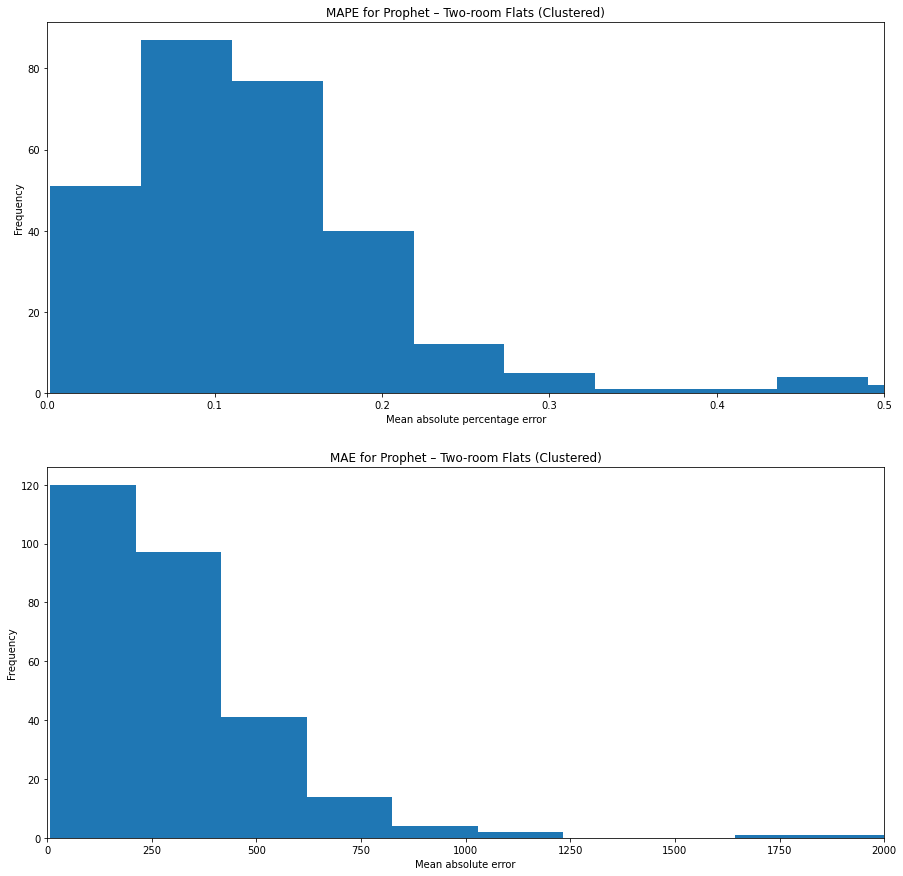

In [118]:
# import matplotlib.pyplot as plt
# PROPHET 

plot_data = pd.DataFrame({"mae":mae_list, "mape": mape_list })
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,15))

ax2 = plot_data["mape"].plot.hist(ax=axes[0])
ax21 = plot_data["mae"].plot.hist(ax=axes[1])
ax2.set_xlim(0,0.5)
ax21.set_xlim(0,2000)
ax2.set_xlabel("Mean absolute percentage error")
ax21.set_xlabel("Mean absolute error")
ax2.set_title("MAPE for Prophet – Two-room Flats (Clustered)")
ax21.set_title("MAE for Prophet – Two-room Flats (Clustered)")

"""ax1 = rm_plot_data["mape"].plot.hist(ax=axes[0,1], color="orange")
ax12 = rm_plot_data["mae"].plot.hist(ax=axes[1,1], color="orange")
ax1.set_xlim(0,0.5)
ax12.set_xlim(0,1000)
ax1.set_xlabel("Mean absolute percentage error")
ax12.set_xlabel("Mean absolute error")
ax1.set_title("MAPE for SARIMAX – Three+-room Flats")
ax12.set_title("MAE for SARIMAX – Three+-room Flats")"""
#fig.savefig("figures/two-room(clustered).png")


In [119]:
print("Prophet")
show_results(plot_data["mae"], plot_data["mape"])
"""print("\nSARIMAX")
show_results(remove_over_100_mae, remove_over_100_mpe)"""

Prophet
Average MAE: 299.155
Median MAE: 245.877
Average MAPE: 0.126
Median MAPE: 0.112


'print("\nSARIMAX")\nshow_results(remove_over_100_mae, remove_over_100_mpe)'

## Same comparison for SARIMAX

In [ ]:
print("\nSARIMAX")
show_results(remove_over_100_mae, remove_over_100_mpe)